# Transformer Networks

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
from IPython.display import SVG
from IPython.display import HTML
%matplotlib inline

In [2]:
style = "<style>img{max-height:400px !important;}</style>"
HTML(style) # this resizes SVGS in my site files.

Most of the paper was clear. However, it was difficult to see how it would work across sequences of different length. I don't mean how or why the positional encoding would work - this is intuitive, but rather how they construct the matrices to fit together :).

This notebook focuses on the unique modules the authors present, and how the system fits together. Other *dependencies* of this post can be viewed at the links below. 

TODO(cjlovering): link other notebooks.

## Overview
This work focuses on the task of natural language translation (e.g. english to german or vice versa.)

<div class="alert alert-info">

I refer to implementations from the 'tensor2tensor' library and 'The Annotated Transformer' post.

</div>

## Encoder Decoder

A encoder-decoder [structure](https://arxiv.org/abs/1409.0473) is used: an input sequence of symbols, $x = { x_1, x_2, \dots, x_n }$, is encoded into a sequence of continuous variables,  $\mathbf{z} = { z_1, z_2, \dots, z_n }$. This is then decoded into a sequence of symbols, $y = { y_1, y_2, \dots, y_n }$. This generation occurs one at a time - it is [auto-regressive](https://arxiv.org/abs/1308.0850), further consuming the previously generated symbols as additional input when generating the next. Encoder and decoder models usually use a recurrent architecture.

## Input Representation

This work used a Byte Pair Encoding scheme. This is a subword tokenization of your vocabulary. This is much more valuable than a UNK symbol. To build this representation, an iterative algorithm can be used to link together the most common segments, starting with character pairs.

## Scaled Dot-Product Attention
The transformer network uses a stateless auto-regressive strategy which will decode the encoded (but not summarized) source words and the current output words. The primary featured used is scaled dot product attention.

The authors describe attention as follows:

> An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors.  The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

In addition to attention, they use a few techniques to regularize their network: layer normalization, residual connections, and dropout.

As noted by the authors, attention maps a query to a combination of given outputs, as determined by the query's corresponding compatibility with the input keys. As the autological "Scaled Dot-Product Attention" method implies, the authors use dot product for their compatibility function. One could use any metric, learned or otherwise. Cosine distance or a layer of MLP can be used.

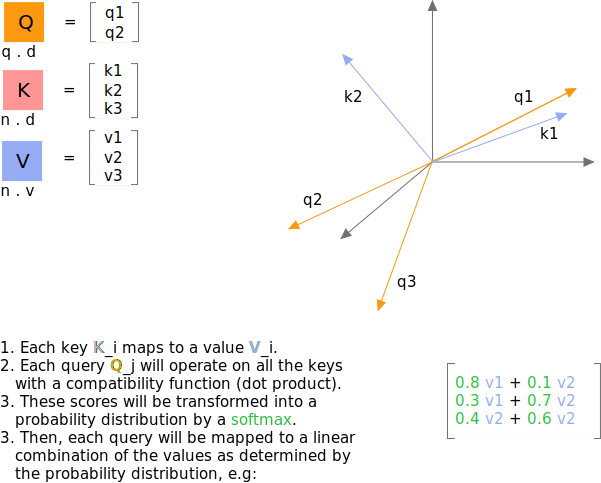

In [3]:
SVG(filename="images/[003]/attention-example.svg")

As shown in the intuitive example above, the query $q_1$ is most similar to $k_1$, thus it is mapped predimately to the corresponding value $v_1$. Note: these values are examples, not necessarily accurate.

The scaled dot product attention is straight forward.

\begin{equation}
A: Q \times K \times V \to O \\
Q\in \mathbf{R}^{q \times d}, K \in \mathbf{R}^{n \times d}, V \in \mathbf{R}^{n \times v}, O \in \mathbf{R}^{q \times v} \\
A = \text{SOFTMAX}(\frac{QK^{\intercal}}{\sqrt{d}}) V
\end{equation}



The innovative aspect of scaled dot product - beyond the authors' apt framing of the problem as an interaction between queries, keys, and values - is the scaling. The author motivate this scaling by noting that the variance of a dot product scales with the size of the input vectors. Increased variance will result in increased magnitude, "pushing the softmax function into regions where it has extremely small gradients."

<div class="alert alert-info">

Why is the gradient small?

</div>

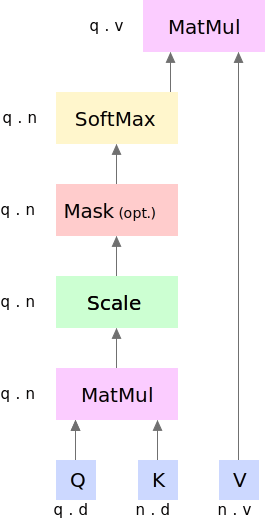

In [4]:
SVG(filename="images/[003]/scaled-dot-product.svg")

Below is an implementation for the scaled dot product. Each line corresponds to a box in the figure above.

In [5]:
def attention(query, key, value, mask=None):
    "Compute 'Scaled Dot Product Attention'"
    # Compatiblity function (dot product) between the query and keys.
    scores = torch.matmul(query, key.transpose(-2, -1))
    # Scale the scores depending on the size of the inputs.
    scores = scores / math.sqrt(query.size(-1))
    # Optional mask. This is used to zero out values that should not be used by this function.
    if mask is not None:    
        scores = scores.masked_fill(mask == 0, -1e9)
    # Compute probability distribution across the final dimension.
    p_attn = F.softmax(scores, dim = -1)
    # Output linear combinations of values, as determined by the distribution.
    return torch.matmul(p_attn, value), p_attn

### Self Attention
With a single query, self attention will have no effect. This is because the attention mechanism will be a linear combination of the values, and it can only reproduce itself so it serves as an identity function.

In [6]:
def SelfAttention(X):
    Q, K, V = X, X, X
    return attention(Q, K, V)

In [7]:
out, alpha = SelfAttention(torch.FloatTensor([[0.1,0.1,0.8]]))
print(out)
print(alpha)

tensor([[0.1000, 0.1000, 0.8000]])
tensor([[1.]])


When there are multiple queries, the vectors that are most *compatible* will become even more similar as they will be mapped to combinations consisting mostly of the already compatible vectors. 

The remaining vector will also be normalized *different*.

In [8]:
X = torch.FloatTensor([
    [0,0,1],
    [0,0,2],
    [1,0,0]
])
out, alpha = SelfAttention(X)
print(alpha)

tensor([[0.2992, 0.5329, 0.1679],
        [0.2228, 0.7070, 0.0702],
        [0.2645, 0.2645, 0.4711]])


Note that, especially with values greater than 1, a vector can have a greater dot product with other vectors rather than itself. So, similarity is aptly not the correct word to describe this interaction (at least when using a dot product). Thus, the first vector is mapped to a construction consisting mostly of itself and the second vector follows the same trend but more extreme. Lastly, the third vector, less compatible than the others - becomes pseduo-normalized.

In [9]:
print(out)

tensor([[0.1679, 0.0000, 1.3650],
        [0.0702, 0.0000, 1.6368],
        [0.4711, 0.0000, 0.7934]])


## Multi Head Attention


The primary representative power of the transformer is "Multi-Head Attention". It is built up using the scaled dot product attention.

Rather than attend raw queries a single time, this method attends *h* linear projections of the input. For each of the *h* heads, the inputs (K,Q,V) are projected linearily with a learned mapping. This is great! Rather than using a single dot product, the multi-headed attention can learn to project vectors and attend them differently. 

<div class="alert alert-info">
Ultimately, the compatiblity function and the projections are all linear - perhaps it would be worth the time to see if non-linear mappings would drastically effect the performance of this method. Does using a feed forward layer here help? hurt?
</div>


\begin{equation}
\text{out} = \texttt{Concat}(\text{head}_0, \dots, \text{head}_h) W^O \\
\text{head}_i = \texttt{Attention}(QW_i^Q, KW_i^K, VW_i^V) \\
Q \in \mathbf{R}^{q \times m}, K \in \mathbf{R}^{n \times m}, V \in \mathbf{R}^{n \times m} \\
W_j^Q, W_j^K, W_j^V \in \mathbf{R}^{m \times d} \\
W^O \in \mathbf{R}^{(h*v)\times m}
\end{equation}

In [10]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)
        
        # 1) Do all the linear projections in batch from d_model => h x d_k 
        query, key, value = \
            [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
             for l, x in zip(self.linears, (query, key, value))]
        
        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        # 3) "Concat" using a view and apply a final linear. 
        x = x.transpose(1, 2).contiguous() \
             .view(nbatches, -1, self.h * self.d_k)
        return self.linears[-1](x)

Thus, the multi-headed attention is a function from $R^{q*d}$ to $R^{q*v}$. Furthermore, like the scaled-dot-product attention, it is able to concurrently operate on all the queries in parallel regardless of the size of the sentence.

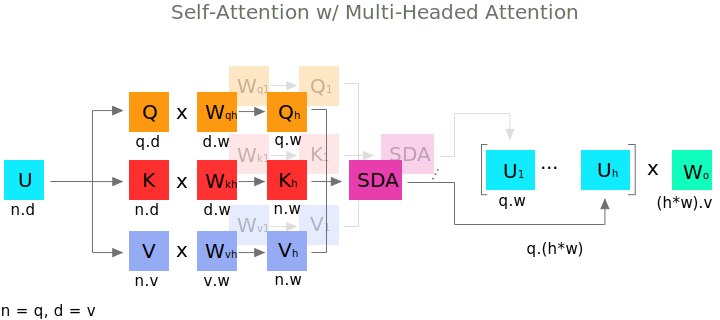

In [11]:
SVG(filename="images/[003]/multi-head.svg")